Assume that you don’t know one or more system parameters. Use the data you have 
stored (add noise to make it interesting) and system identification methods like least 
squares to estimate parameters. Cross-check your results against actual values. 
Investigate the effect of noise or missing data.

In [12]:
import sqlite3
import redis
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.signal import savgol_filter

In [13]:
# parameters
g0  = 9.81     # [m.s^2] accerelation of gravity
#mass  = 0.033    # [kg] total mass (with one marker)
Ixx = 1.395e-5   # [kg.m^2] Inertia moment around x-axis
Iyy = 1.395e-5   # [kg.m^2] Inertia moment around y-axis
Izz = 2.173e-5   # [kg.m^2] Inertia moment around z-axis
Cd  = 7.9379e-06 # [N/krpm^2] Drag coef
Ct  = 3.25e-4    # [N/krpm^2] Thrust coef
dq  = 65e-3      # [m] distance between motors' center

arm_length = dq/2.0  # The length of the motor lever arm (m)
max_thrust = 0.1573     # Maximum thrust of a single motor (N) (max = 22krpm)
max_torque = 3.842e-03  # Maximum torque of a single motor (Nm) (max = 22krpm)

# 100Hz 10ms 0.01s
t0, t_end = 0, 10  # Time range (seconds)
dt = 0.01  # Time step (seconds)
N = int((t_end - t0) / dt)  # Number of steps
t_pts = np.linspace(t0, t_end, N + 1)

In [14]:
# Database configuration
file_name = 'quadcopter.db'
# Redis
pool = redis.ConnectionPool(host='localhost', port=6379, db=0, decode_responses=True)
r = redis.Redis(connection_pool=pool)

# SQLite
conn = sqlite3.connect(file_name)
cur = conn.cursor()

In [15]:
delete_data = "UPDATE quadcopter_states SET Velocity_bx = '0' WHERE Timestamp = 0.01"
cur.execute(delete_data)
conn.commit()

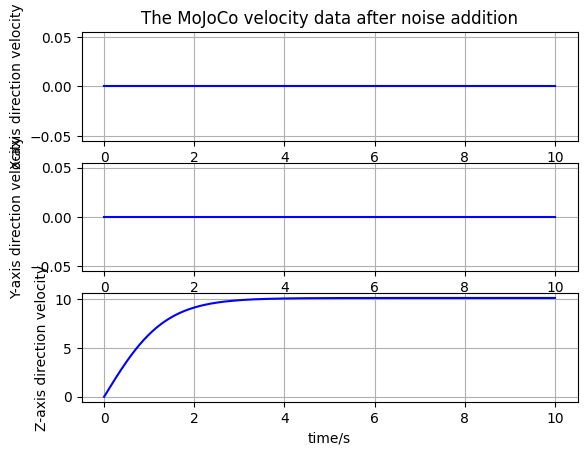

In [16]:
select_vel = "SELECT Velocity_bx,Velocity_by,Velocity_bz FROM quadcopter_states"
cur.execute(select_vel)
vel = cur.fetchall()


# Missing data: handle, interpolate
for i, items in enumerate(vel):
    for j, item in enumerate(items):
        if item == 'NULL':
            vel[i][j] = 0.5 * (vel[i][j+1] + vel[i][j-1])
            print(vel[i][j])
        pass

fig, ax = plt.subplots(3, 1)
ax[0].set(title='The MoJoCo velocity data after noise addition')
lable = ['X', 'Y', 'Z']
for i in range(3):
    ax[i].plot(t_pts, [list(vel[j])[i] for j in range(N+1)], "b-", label = "data")
    ax[i].set(xlabel='time/s', ylabel=f'{lable[i]}-axis direction velocity')
    #ax[i].legend()
    ax[i].grid()
plt.show()

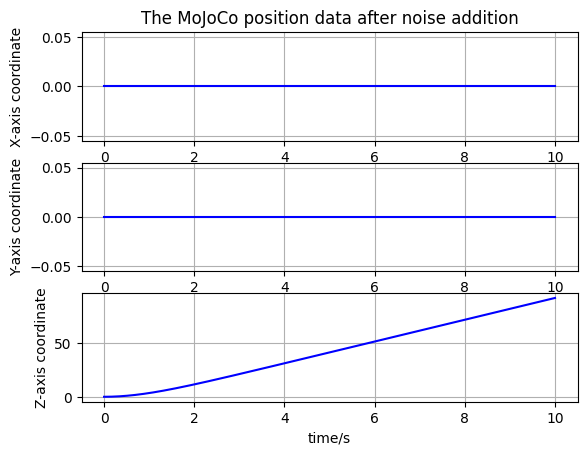

In [17]:
select_pos = "SELECT X_axis_coordinate,Y_axis_coordinate,Z_axis_coordinate FROM quadcopter_states"
cur.execute(select_pos)
pos = cur.fetchall()
#print([list(pos[i])[0] for i in range(N+1)])


fig, bx = plt.subplots(3, 1)
bx[0].set(title='The MoJoCo position data after noise addition')
lable = ['X', 'Y', 'Z']
for i in range(3):
    bx[i].plot(t_pts, [list(pos[j])[i] for j in range(N+1)], "b-", label = "data")
    bx[i].set(xlabel='time/s', ylabel=f'{lable[i]}-axis coordinate')
    #bx[i].legend()
    bx[i].grid()
plt.show()

[least_squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html)

The function of velocity is:

```python
vz_d = Ct*(w1**2 + w2**2 + w3**2 + w4**2) / mass - wz*vz - 2*(0.5 - q1**2 - q2**2)*g0 - (0.00242*vz*abs(vz))/mass
```

The dynamic equation in the z-axis direction under the body coordinate system:
$$
\dot{v}_z = \frac{C_t \sum w_i^2}{m} - \omega_z v_z - 2\left(0.5 - q_1^2 - q_2^2\right)g_0 - \frac{0.00242 v_z |v_z|}{m}
$$

Rewrite it into a linear form with respect to \(m \) :
$$
\underbrace{C_t \sum w_i^2 - 0.00242 v_z |v_z|}_{A} = m \underbrace{\left(\dot{v}_z + \omega_z v_z + 2\left(0.5 - q_1^2 - q_2^2\right)g_0\right)}_{B}
$$

That is:
$$
A = m \cdot B
$$

#### **Method 1：Least Square**

In [18]:
def estimate_mass(t, vz, vz_dot, w, wz, q1, q2, Ct, g0=9.81):
    """
    Estimate the mass m by least squares
    Parameter:
        t: Time series (N,)
        vz: Vertical velocity (N,)
        vz_dot: Vertical acceleration (N,)
        w: Motor speed matrix (N,4)
        wz: Yaw angular velocity (N,)
        q1,q2: Quaternion component (N,)
        Ct: Thrust coefficient
        g0: Gravitational acceleration
    Return:
        Estimated mass (kg)
    """
    # Calculate items A and B
    A = Ct * np.sum(w**2, axis=1) - 0.00242 * vz * abs(vz)
    B = vz_dot + wz * vz + 2 * (0.5 - q1**2 - q2**2) * g0
    print(np.divide(A, B))
    
    # Least squares solution m = A/B
    m = np.linalg.lstsq(B.reshape(-1,1), A.reshape(-1,1), rcond=None)[0][0][0]
    return m

#### **Method 2：Recursion of difference equations**

In [19]:
class RecursiveMassEstimator:
    def __init__(self, Ct, g0=9.81, lambda_=0.99):
        self.P = 1e6  # The initial value of covariance
        self.m = 1.0  # Initial guess of mass (kg)
        self.Ct = Ct
        self.g0 = g0
        self.lambda_ = lambda_  # variable forgetting factor
        
    def update(self, vz, vz_dot, w, wz, q1, q2):
        A = self.Ct * np.sum(w**2) - np.multiply(vz, np.abs(vz)) * 0.00242
        B = vz_dot + wz * vz + 2 * (0.5 - q1**2 - q2**2) * self.g0
        
        # RLS
        K = self.P * B / (self.lambda_ + B * self.P * B)
        self.m += K * (A - B * self.m)
        self.P = (self.P - K * B * self.P) / self.lambda_
        return self.m

In [20]:
def compute_acceleration(vz, t):
    """Calculate the acceleration"""
    vz_dot = [0]
    for i in range(len(vz) - 1):
        vz_dot.append((vz[i+1]-vz[i])/t)
    return np.gradient(vz, t)


In [21]:
g0  = 9.81     # [m.s^2] accerelation of gravity
mass  = 0.033    # [kg] total mass (with one marker)
Ixx = 1.395e-5   # [kg.m^2] Inertia moment around x-axis
Iyy = 1.395e-5   # [kg.m^2] Inertia moment around y-axis
Izz = 2.173e-5   # [kg.m^2] Inertia moment around z-axis
Cd  = 7.9379e-06 # [N/krpm^2] Drag coef
Ct  = 3.25e-4    # [N/krpm^2] Thrust coef
dq  = 65e-3      # [m] distance between motors' center

arm_length = dq/2.0  # The length of the motor lever arm (m)
max_thrust = 0.1573     # Maximum thrust of a single motor (N) (max = 22krpm)
max_torque = 3.842e-03  # Maximum torque of a single motor (Nm) (max = 22krpm)

t0, t_end = 0, 10  # Time range (seconds)
dt = 0.01  # Time step (seconds)
N = int((t_end - t0) / dt)  # Number of steps
t_pts = np.linspace(t0, t_end, N)

select_v = "SELECT Velocity_bz FROM quadcopter_states"
cur.execute(select_v)
v = cur.fetchall()
vz = [list(v[j])[0] for j in range(N+1)]
vz = np.array(vz, dtype=float)
vz_dot = compute_acceleration(vz, dt)
vz_dot = np.array(vz_dot, dtype=float)

w = [21, 21, 21, 21]
ws = np.full((N+1, 4), w)

select_w = "SELECT Angular_velocity_bz FROM quadcopter_states"
cur.execute(select_w)
w = cur.fetchall()
wz = [list(w[j])[0] for j in range(N+1)]
wz = np.array(wz, dtype=float)

select_q = "SELECT Quaternion_x,Quaternion_y FROM quadcopter_states"
cur.execute(select_q)
q = cur.fetchall()
q1 = [list(q[j])[0] for j in range(N+1)]
q1 = np.array(q1, dtype=float)
q2 = [list(q[j])[1] for j in range(N+1)]
q2 = np.array(q2, dtype=float)

estimate_mass(dt, vz, vz_dot, ws, wz, q1, q2, Ct, g0=9.81)

[0.03300029 0.0330003  0.03300034 ... 0.0330086  0.0330086  0.0330086 ]


np.float64(0.0330065801098789)

In [22]:
cur.close()
conn.close()